## Combine GroundingDINO with SegmentAnythingModel
- Use [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) for zero-shot object detection (bboxes)
- Use Segment Anything Model ([SAM](https://github.com/facebookresearch/segment-anything)) for converting detections into segmentations

***
## Imports and Installs

In [50]:
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
from torchvision import transforms as T

In [ ]:
%pip install -qqq git+https://github.com/tkra90/magic.git

In [3]:
import tinymagic

***
### Install SAM & Load Weights

In [5]:
%pip install -qqq git+https://github.com/facebookresearch/segment-anything.git

Note: you may need to restart the kernel to use updated packages.


In [48]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

***
### Install GroundingDINO & Download Weights 

In [4]:
%%capture

!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
%pip install -qqq -e .

# download weights
%mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd ..

In [43]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util import box_ops

dino_model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")
dino_model.to(device);

final text_encoder_type: bert-base-uncased


***
### Load dataset

In [17]:
FLOOD_DS_ROOT = '/kaggle/input/flood-area-segmentation'
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_files = sorted(glob(FLOOD_DS_ROOT+"/Image/*"))

image_source, image = load_image(image_files[7])

***
### Detect Bounding Boxes with GroundingDINO

In [33]:
%%time

TEXT_PROMPT = "houses with white roof "

boxes, logits, phrases = predict(
    model=dino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

CPU times: user 235 ms, sys: 1.57 ms, total: 237 ms
Wall time: 231 ms


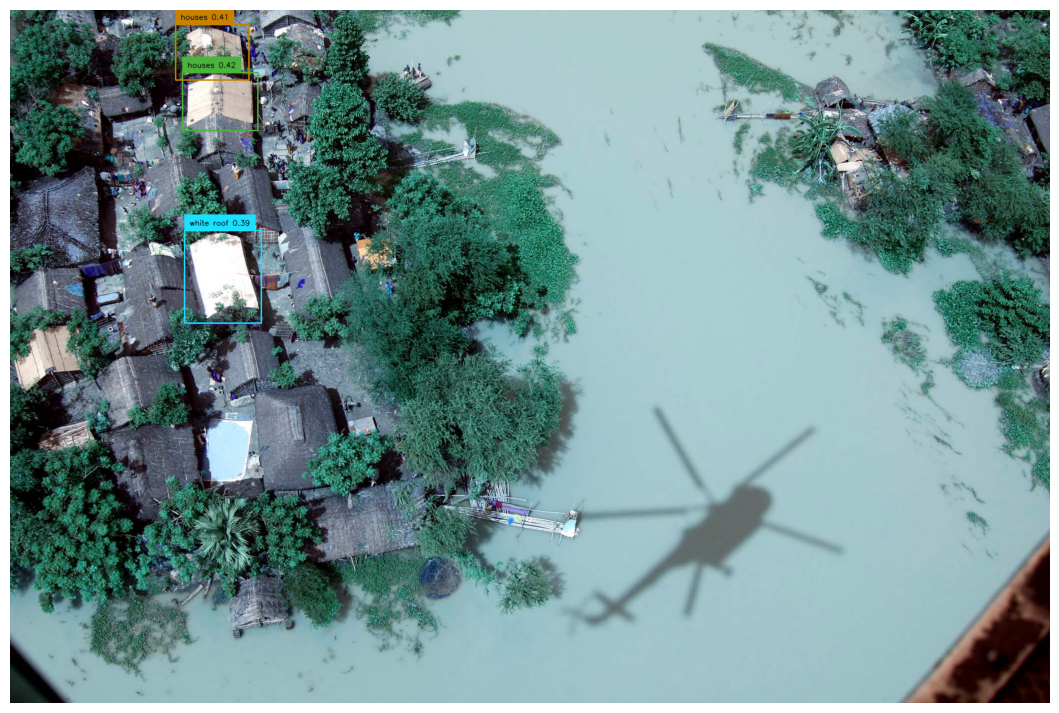

In [34]:
plt.figure(figsize=(16,9))
plt.axis('off')
plt.imshow(annotated_frame);

***
### Predict Masks with SAM

In [39]:
H,W,_ = image_source.shape
H,W

(1400, 2100)

In [45]:
boxes

tensor([[0.2048, 0.3851, 0.0737, 0.1342],
        [0.2021, 0.1321, 0.0722, 0.0838],
        [0.2048, 0.3851, 0.0735, 0.1337],
        [0.1945, 0.0609, 0.0705, 0.0799]])

In [36]:
image_source.shape

(1400, 2100, 3)

In [8]:
device

device(type='cuda')